# Aula 07


In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor


In [131]:
link = 'https://raw.githubusercontent.com/FLS-6497/datasets/main/aula7/eleicoes2000.csv'
dados = pd.read_csv(link, sep=';', decimal=",").drop(['cod_mun_ibge', 'nome_municipio'], axis=1)

## 1) Bagging
Para esse exercício, precisaremos de novos dados, dessa vez das eleições municípais de 2000. A base que usaremos indica qual partido venceu, se PMDB/PSDB/PFL ou outros, e variáveis econômicas e demográficas (não se esqueça de remover IDs e nome dos municípios, como cod_mun_ibge e nome_municipio; se usar Python, também não se esqueça de transformar/remover as variáveis uf e coligacao):1

In [132]:
dados.head()

,uf,partido,coligacao,n_partidos,espvida,mort1,e_anosestudo,t_analf25m,ppob,rdpc,agua_esgoto,i_escolaridade,p_super,t_des18m,gini
0,AC,PMDB-PSDB-PFL,Coligado,4,68.43,25.45,8.71,18.62,50.89,527.43,29.90,0.425,7.26,13.48,0.61
1,AC,PMDB-PSDB-PFL,Coligado,3,67.39,28.33,6.58,48.37,79.68,238.86,28.34,0.165,2.02,3.95,0.64
2,AC,PMDB-PSDB-PFL,Coligado,2,66.07,32.20,6.96,37.73,74.50,217.70,42.23,0.173,1.23,14.94,0.54
3,AL,Outros,Coligado,3,64.21,46.61,4.98,62.15,91.77,98.98,23.72,0.098,0.00,0.85,0.66
4,AL,Outros,Coligado,5,63.52,49.30,6.60,39.73,87.35,168.82,14.90,0.192,1.03,39.90,0.55


In [133]:
dados['partido'].unique()

array(['PMDB-PSDB-PFL', 'Outros'], dtype=object)

### a) Exploração
Explore rapidamente a base de dados. Para tanto, você pode criar gráficos com as distribuições do target e de algumas features, com cruzamentos das variáveis ou, ainda, usar correlações. Quais variáveis parecem ter mais relação com o target partido?

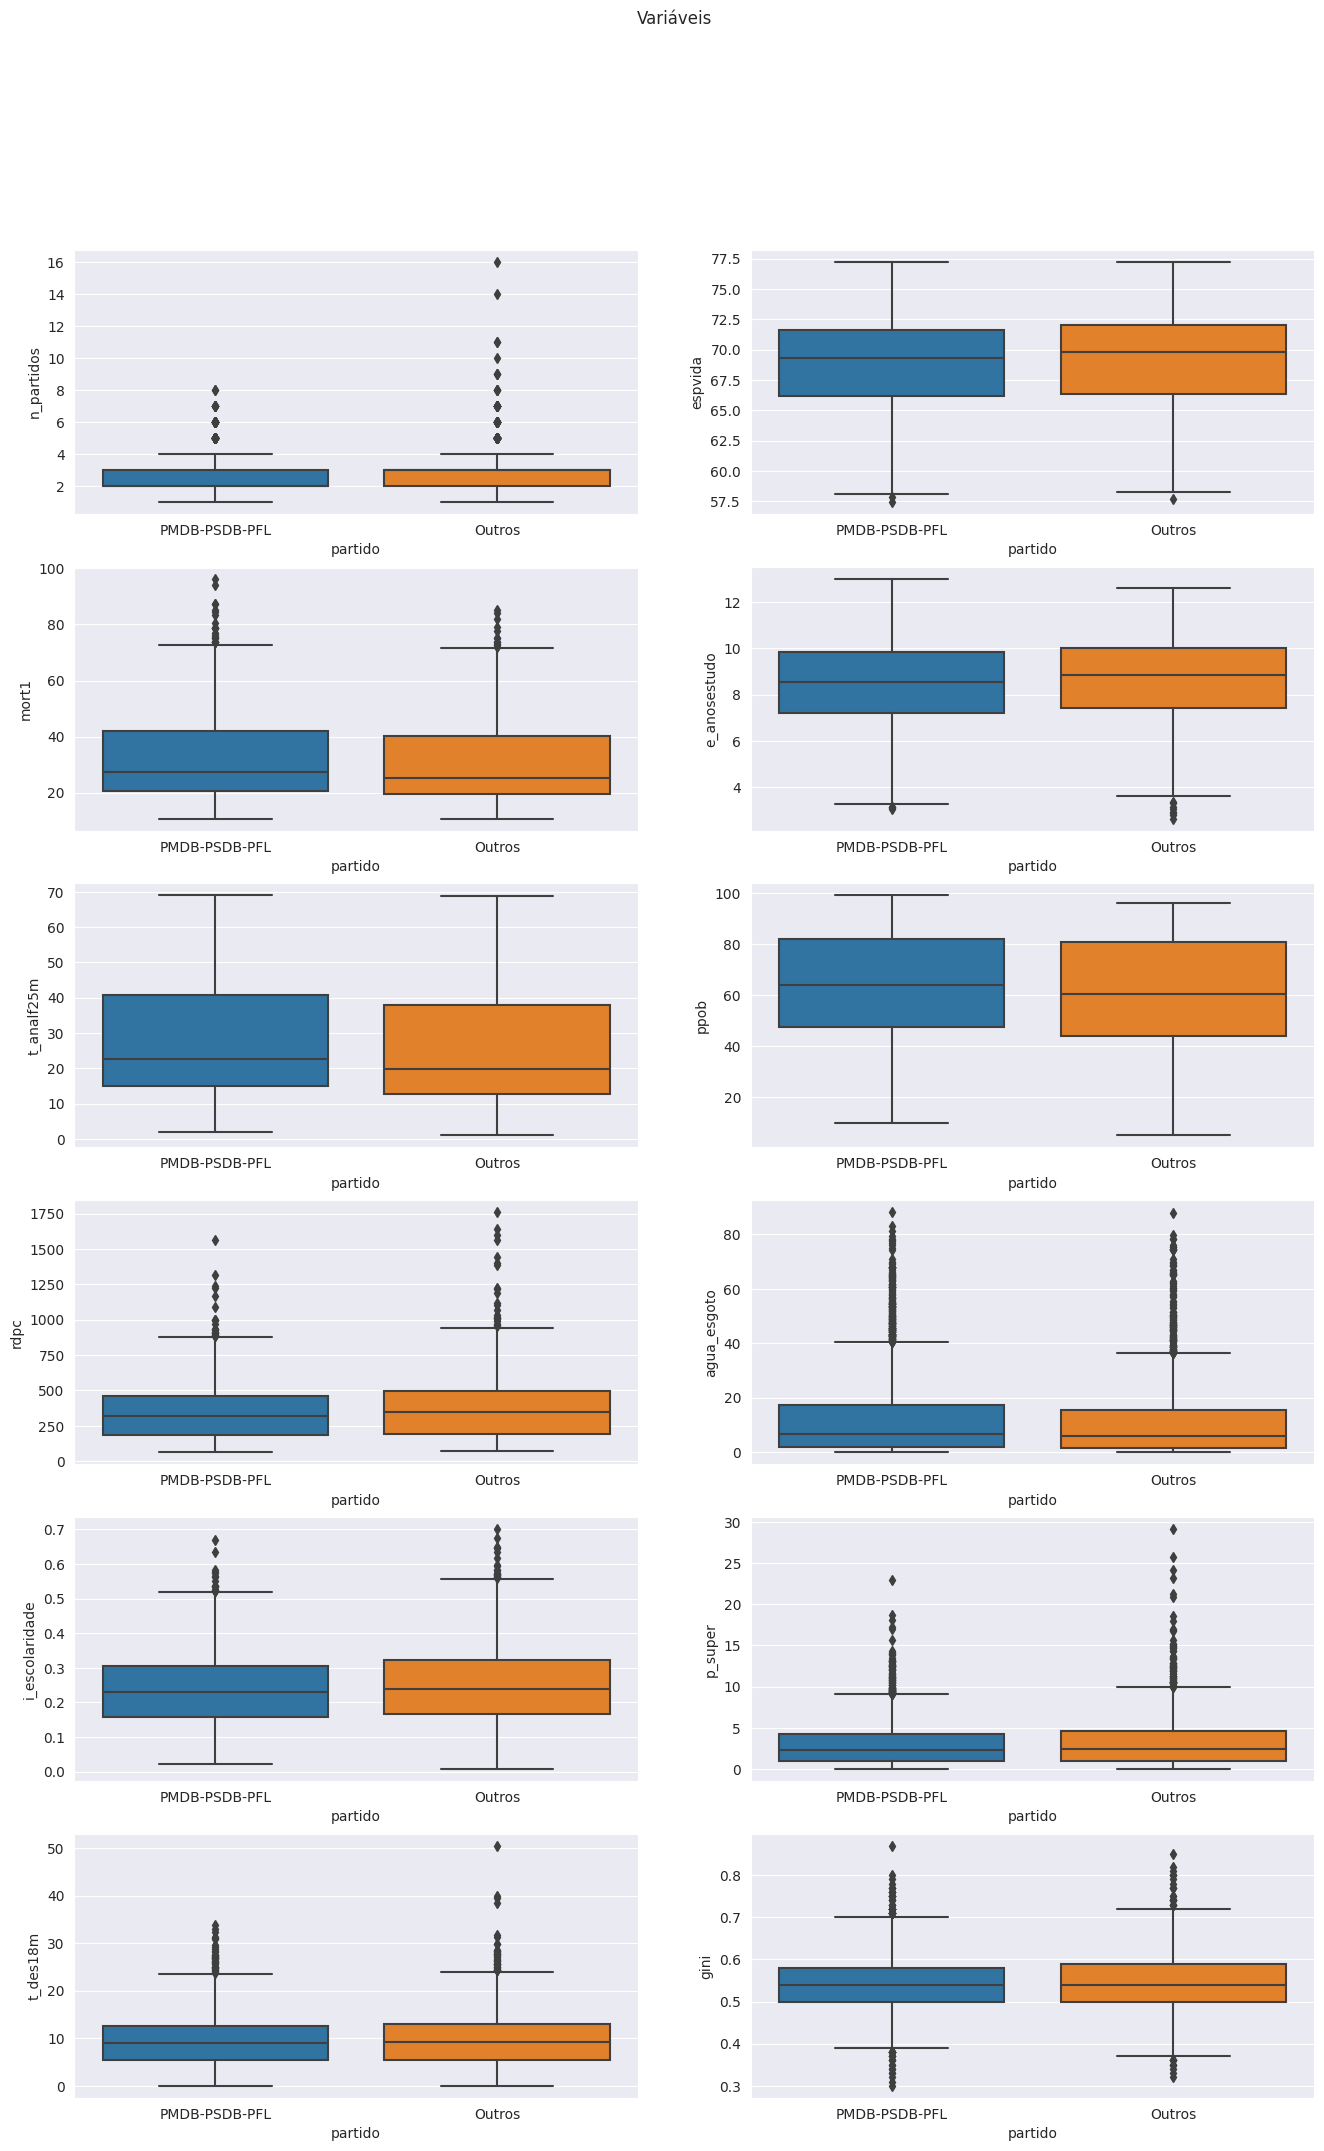

In [134]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(6,2,figsize=(16,24))
fig.suptitle("Variáveis")

#for i in range(0,4):
#    temp = dados.iloc[:,i+3]
#    nome = dados.columns[i+3]
#    sns.boxplot(ax=ax[i],y=temp)
#    ax[i].set_title(nome)
#    ax[i].set(ylabel="Recall")

for i in range(0,12):
    linha, coluna = divmod(i,2)
    x = dados.iloc[:,1]
    temp = dados.iloc[:,i+3]
    nome = dados.columns[i+3]
    sns.boxplot(ax=ax[linha,coluna],y=temp,x=x)
    #ax[linha,coluna].set_title(nome)
    #ax[linha,coluna].set(ylabel="Recall")


### b) Criação de pipelines com bagging
Usando pipelines, crie um bagging ensemble combinando quantos e quais modelos você quiser e outra pipeline usando Naive Bayes. Treine e compare os resultados destas pipelines.

In [135]:
dados.columns

Index(['uf', 'partido', 'coligacao', 'n_partidos', 'espvida', 'mort1',
       'e_anosestudo', 't_analf25m', 'ppob', 'rdpc', 'agua_esgoto',
       'i_escolaridade', 'p_super', 't_des18m', 'gini'],
      dtype='object')

In [136]:
dados_modelos = dados
dados_modelos.drop(['uf','coligacao'], axis=1, inplace=True)
dados_modelos.columns


Index(['partido', 'n_partidos', 'espvida', 'mort1', 'e_anosestudo',
       't_analf25m', 'ppob', 'rdpc', 'agua_esgoto', 'i_escolaridade',
       'p_super', 't_des18m', 'gini'],
      dtype='object')

In [137]:
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

Y = dados_modelos['partido']
X = dados_modelos.loc[:, dados_modelos.columns != 'partido']

X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y)

# Treina os modelos
arvore = DecisionTreeClassifier().fit(X_treino, Y_treino)

bagging = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=10,
).fit(X_treino, Y_treino)

# Calcula metricas
pred_arvore = arvore.predict(X_teste)
cm1 = metrics.accuracy_score(Y_teste, pred_arvore)

pred_bagging = bagging.predict(X_teste)
cm2 = metrics.accuracy_score(Y_teste, pred_bagging)


In [138]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

nb = MultinomialNB()

bagging_rf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=10,
).fit(X_treino, Y_treino)

bagging_nb = BaggingClassifier(
    base_estimator=MultinomialNB(),
    n_estimators=10,
).fit(X_treino, Y_treino)

pred_bagging_rf = bagging_rf.predict(X_teste)
pred_bagging_nb = bagging_nb.predict(X_teste)

acc1 = metrics.accuracy_score(Y_teste, pred_bagging_rf)
acc2 = metrics.accuracy_score(Y_teste, pred_bagging_nb)
print(acc1,acc2)

0.5447284345047924 0.5223642172523961


### c) Variações
Agora, crie outros dois bagging ensembles, um deles fazendo subsample dos dados (no mlr3, isso é controlado pelo argumento frac no po com subsample) e, o outro, utilizando um modelo diferente do que você utilizou na bagg anterior. Treine e compare os resultados destas novas pipelines.

### d) Random forest
Crie uma pipeline agora usando random forest (fique à vontade para customizar ela como achar melhor) e compare seus resultados com o da melhor pipeline que você encontrou no exercício anterior.

In [139]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

nb = MultinomialNB()

bagging_rf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=10,
    bootstrap=False,
    max_samples=0.3,
    max_features=0.8
).fit(X_treino, Y_treino)

bagging_nb = BaggingClassifier(
    base_estimator=MultinomialNB(),
    n_estimators=10,
    bootstrap=False,
    max_samples=0.3,
    max_features=0.8
).fit(X_treino, Y_treino)

pred_bagging_rf = bagging_rf.predict(X_teste)
pred_bagging_nb = bagging_nb.predict(X_teste)

acc1 = metrics.accuracy_score(Y_teste, pred_bagging_rf)
acc2 = metrics.accuracy_score(Y_teste, pred_bagging_nb)
print(acc1,acc2)

0.5231629392971247 0.5303514376996805


## 2) Stacking
### a) Básico
Adaptando o exemplo dos materiais de aula, crie uma pipeline que use stacking para combinar os resultados de três modelos diferentes. Os modelos de nível 0 podem ter tanto etapas de pré-processamento, modelos ou parâmetros diferentes (e.g., é possível treinar 3 árvores diferentes). Como blender, use um modelo de regressão logística simples (no mlr3, classif.log_ref; no sklearn, LogisticRegression). Treine e veja os resultados desta pipeline.

In [140]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

modelos = [('nb', MultinomialNB()),
           ('kknn', KNeighborsClassifier()),
           ('rf', RandomForestClassifier(n_estimators=50))
          ]

stack = StackingClassifier(estimators=modelos, final_estimator=LogisticRegressionCV())\
    .fit(X_treino, Y_treino)

# Calcula metricas
pred = stack.predict(X_teste)
acc2 = metrics.accuracy_score(Y_teste, pred)
print(acc2)

0.6014376996805112


### 3) Boosting
Para quem usa R, neste exercício será necessário converter features categóricas para numeric (o XGboost só aceita variáveis numéricas). Podemos criar uma nova base assim com o seguinte código:

In [141]:
from xgboost import XGBRegressor,XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

Y = dados_modelos['partido']
Y = Y.replace('PMDB-PSDB-PFL',1)
Y = Y.replace('Outros',0)
X = dados_modelos.loc[:, dados_modelos.columns != 'partido']

X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y)


# Treina os modelos
gb = GradientBoostingClassifier(n_estimators=50)\
    .fit(X_treino, Y_treino)

xgb = XGBClassifier(n_estimators=50)\
    .fit(X_treino, Y_treino)

# Calcula metricas
pred = gb.predict(X_teste)

acc1 = metrics.accuracy_score(Y_teste, pred)
pred = xgb.predict(X_teste)

acc2 = metrics.accuracy_score(Y_teste, pred)
print(acc1,acc2)

0.6086261980830671 0.5926517571884984


### 4) Validação
Usando o melhor ensemble que você encontrou nessa aula, o valide usando estes dados das eleições de 2004 – que foram um pouco diferentes das de 2000 em termos de desempenho dos partidos (lembre-se de que é preciso treinar do zero o melhor modelo nos dados completos de 2000 antes de fazer a validação).2.

In [144]:
link = 'https://raw.githubusercontent.com/FLS-6497/datasets/main/aula7/eleicoes2004.csv'
dados = pd.read_csv(link, sep=';', decimal=",").drop(['cod_mun_ibge', 'nome_municipio', 'uf','coligacao'], axis=1)

In [149]:
dados_modelos_14 = dados

Y_14 = dados_modelos_14['partido']
Y_14 = Y_14.replace('PMDB-PSDB-PFL',1)
Y_14 = Y_14.replace('Outros',0)
X_14 = dados_modelos_14.loc[:, dados_modelos_14.columns != 'partido']

Y = dados_modelos['partido']
Y = Y.replace('PMDB-PSDB-PFL',1)
Y = Y.replace('Outros',0)
X = dados_modelos.loc[:, dados_modelos.columns != 'partido']

X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y)


# Treina os modelos
gb = GradientBoostingClassifier(n_estimators=50)\
    .fit(X_treino, Y_treino)

# Calcula metricas
pred = gb.predict(X_14)

acc1 = metrics.accuracy_score(Y_14, pred)
print(acc1)

0.5167190097912433
